In [1]:
import sklearn
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, get_all_preds, fit, UCRDataset
from ClassificationModels.LSTM import LSTMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd
from tslearn.datasets import UCR_UEA_datasets
import os 

# Parameters

In [2]:
#TODO Cope with different dimensionalities btw autoencoder and model ! 
dataset='ElectricDevices'

# Load Data

In [3]:

train_x,train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)

In [4]:
enc1=pickle.load(open(f'../../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','rb'))
train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))

/home/jacqueline/.local/share/virtualenvs/TSInterpret-NXJYnQDU/lib/python3.7/site-packages/sklearn/base.py:338: UserWarning: Trying to unpickle estimator OneHotEncoder from version 0.24.2 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  UserWarning,


In [5]:
full_x= np.vstack([train_x, test_x])
full_y= np.vstack([train_y, test_y])

In [6]:
# New Train/ Test Split with 0.33
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( full_x, full_y, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split( X_train, y_train, test_size=0.33, random_state=42)

# Model Training

In [7]:
#TODO Load Data and make this new
n_pred_classes =train_y.shape[1]
train_dataset = UCRDataset(X_train.astype(np.float64),y_train.astype(np.int64))
test_dataset = UCRDataset(X_test.astype(np.float64),y_test.astype(np.int64))
val_dataset = UCRDataset(X_val.astype(np.float64),y_val.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=256,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=256,shuffle=False)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=1,shuffle=False)
input_dim = 1   
hidden_dim = 256
layer_dim = 1
output_dim =n_pred_classes
model = LSTMClassifier(input_dim, hidden_dim, layer_dim, output_dim)
model.load_state_dict(torch.load(f'../../ClassificationModels/models/{dataset}/LSTM'))
model.eval()

LSTMClassifier(
  (rnn): LSTM(1, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=7, bias=True)
)

# Explanation Algo

In [8]:
#from TSInterpret.InterpretabilityModels.TSInsight.TSInsightPYT import TSInsightPYT
#exp_model=TSInsightPYT(model,(train_x.shape[-2],train_x.shape[-1]),(train_x,train_y), (test_x,test_y),autoencoder='cnn' )

In [9]:
# save model 
#torch.save(model.state_dict(), f'../../ClassificationModels/models/{dataset}/TSInsightAutoencoder_LSTM_Class')

In [10]:
from TSInterpret.InterpretabilityModels.TSInsight.PYT_AE.CNN_PYT import ConvAutoencoder
from TSInterpret.InterpretabilityModels.TSInsight.TSInsightPYT import TSInsightPYT
#TODO make model decision according to val !
#autoencoder= ConvAutoencoder(1)
#autoencoder.load_state_dict(torch.load(f'../../ClassificationModels/models/{dataset}/TSInsightAutoencoder_LSTM_Class'))
exp_model=TSInsightPYT(model,(train_x.shape[-2],train_x.shape[-1]),(train_x,train_y), (test_x,test_y), autoencoder='cnn')

2022-08-02 16:25:19.059594: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-02 16:25:19.059611: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<class 'str'>
cnn ae flag True
cnn_model False
INFO - Provided Datasets are Tuples. Create a Default DataLoader.
Epoch: 0, Train loss: 0.013, Validation loss: 0.118
Epoch: 1, Train loss: 0.013, Validation loss: 0.106
Epoch: 2, Train loss: 0.004, Validation loss: 0.099
Epoch: 3, Train loss: 0.016, Validation loss: 0.12
Epoch: 4, Train loss: 0.002, Validation loss: 0.096
Epoch: 5, Train loss: 0.009, Validation loss: 0.096
Epoch: 6, Train loss: 0.016, Validation loss: 0.102
Epoch: 7, Train loss: 0.002, Validation loss: 0.103
Epoch: 8, Train loss: 0.001, Validation loss: 0.091
Epoch: 9, Train loss: 0.002, Validation loss: 0.09
Epoch: 10, Train loss: 0.18, Validation loss: 0.095
Epoch: 11, Train loss: 0.016, Validation loss: 0.096
Epoch: 12, Train loss: 0.005, Validation loss: 0.089
Epoch: 13, Train loss: 0.003, Validation loss: 0.088
Epoch: 14, Train loss: 0.012, Validation loss: 0.097
Epoch: 15, Train loss: 0.005, Validation loss: 0.083
Epoch: 16, Train loss: 0.01, Validation loss: 0.115


In [11]:
item=X_val[0].reshape(1,-1,1)
shape=item.shape
_item=  torch.from_numpy(item).float()
model.eval()
y_target = torch.nn.functional.softmax(model(_item)).detach().numpy()

In [12]:
exp=exp_model.explain(item)

In [13]:
np.count_nonzero(item.flatten()-exp.flatten())

96

(1, 1, 96)
(1, 96, 1)


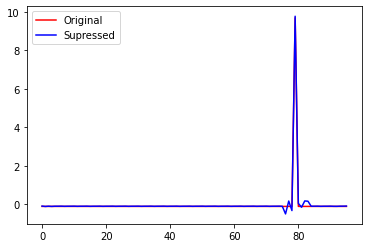

In [14]:
exp_model.plot(item, exp)

<AxesSubplot:>

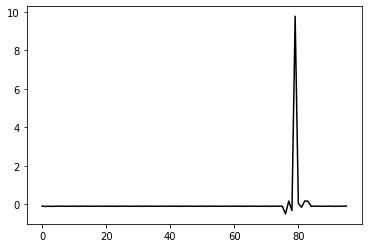

In [15]:
sns.lineplot(x=range(0,len(exp.reshape(-1))), y=exp.flatten(), color='black')

In [16]:
#print(exp)

In [17]:
#print(exp.shape)

# Plot Item 

In [18]:

#exp_model.plot(item,np.argmax(y_target,axis=1)[0],exp,label)

In [19]:
#xp_model.plot_in_one(item,np.argmax(y_target,axis=1)[0],exp,label)